# Sentiment Analysis

## Get the closing prices of Microsoft

In [1]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
%matplotlib inline

# Load .env environment variables
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Format current date as ISO format
start_date = pd.Timestamp("2009-09-21", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-01-16", tz="America/New_York").isoformat()

# Set the tickers
ticker = "MSFT"

# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"

# Get current closing prices
df_closing_prices = alpaca.get_barset(
    ticker,
    timeframe,
    start = start_date,
    end = end_date
).df

# Dissolve multiindex and fetch the closing prices 
df_closing_prices = df_closing_prices.droplevel(0, axis=1)[['close']]

# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date

# Display sample data
df_closing_prices.head()


Bad key "text.kerning_factor" on line 4 in
C:\Users\kn_na\anaconda3\envs\x\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


,close
2009-09-21,25.30
2009-09-22,25.77
2009-09-23,25.71
2009-09-24,25.93
2009-09-25,25.57


In [2]:
df_closing_prices['return'] = df_closing_prices['close'].pct_change()
df_closing_prices.dropna(inplace=True)
df_closing_prices.head()

,close,return
2009-09-22,25.77,0.018577
2009-09-23,25.71,-0.002328
2009-09-24,25.93,0.008557
2009-09-25,25.57,-0.013884
2009-09-28,25.88,0.012124


## Load the data of google research results

In [3]:
import pandas as pd
from pathlib import Path
import calendar
from sklearn.preprocessing import LabelEncoder

file_path = Path("../companies_tweet_data/microsoft.csv")
news_df = pd.read_csv(file_path, parse_dates=[['date','time']], infer_datetime_format=True, usecols=['date',"tweet",'time'])

# Delete the index label and sort in ascending order
news_df.set_index('date_time', inplace=True)
news_df.index.name = None
news_df.sort_index(axis=0, inplace=True)

# Display sample data
print(len(news_df))
display(news_df.head())

27082


,tweet
2009-09-21 13:19:33,Hi Twittersphere! This is the official page fo...
2009-09-21 13:19:33,Hi Twittersphere! This is the official page fo...
2009-09-21 14:40:40,Wanna get get game smart? Check out our tips h...
2009-09-21 14:40:40,Wanna get get game smart? Check out our tips h...
2009-09-23 14:33:20,Want to see friends and family in HD? Now you ...


In [4]:
# Drop news published after 4pm since it does not affect the closing price of that day
news_df = news_df.between_time('00:00:00','15:59:59', include_end=False)

# Drop time in the index labels
news_df.index = news_df.index.date

# Display sample data
print(len(news_df))
display(news_df.head())

13636


,tweet
2009-09-21,Hi Twittersphere! This is the official page fo...
2009-09-21,Hi Twittersphere! This is the official page fo...
2009-09-21,Wanna get get game smart? Check out our tips h...
2009-09-21,Wanna get get game smart? Check out our tips h...
2009-09-23,Want to see friends and family in HD? Now you ...


## Sentiment Analysis

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kn_na\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# Create the Facebook Libra sentiment scores DataFrame
sentiments = []

for title in news_df["tweet"]:
    try:
        sentiment = analyzer.polarity_scores(title) # get sentiment score
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        sentiments.append({"compound": compound,
                                 "positive": pos,
                                 "negative": neg,
                                 "neutral": neu
                                })
        
    except AttributeError:
        pass
    
# Create DataFrame
sentiments_df = pd.DataFrame(sentiments, index=news_df.index)

# Reorder DataFrame columns
news_df = news_df.join(sentiments_df)

news_df.head()

,tweet,compound,negative,neutral,positive
2009-09-21,Hi Twittersphere! This is the official page fo...,0.0000,0.0,1.000,0.000
2009-09-21,Hi Twittersphere! This is the official page fo...,0.0000,0.0,1.000,0.000
2009-09-21,Hi Twittersphere! This is the official page fo...,0.4019,0.0,0.787,0.213
2009-09-21,Hi Twittersphere! This is the official page fo...,0.4019,0.0,0.787,0.213
2009-09-21,Hi Twittersphere! This is the official page fo...,0.0000,0.0,1.000,0.000


In [7]:
# sentiment_score_df = pd.DataFrame(index=news_df.index)
# sentiment_score_df.head()

In [8]:
# calculate the average of compound scores for a day with more than 1 article
import numpy as np
# sentiment_score_df = news_df.groupby(level=0)[['compound']].agg([('avg_sentiment',np.mean), ('article_counts',count)])
sentiment_score_df = news_df.groupby(level=0)[['compound']].count()
sentiment_score_df["avg_sentiments"] = news_df.groupby(level=0)[['compound']].mean()
sentiment_score_df.rename(columns= {'compound':"article_counts"}, inplace=True)
sentiment_score_df.head()

,article_counts,avg_sentiments
2009-09-21,16,0.200950
2009-09-23,16,0.263350
2009-09-24,36,0.013567
2009-09-25,16,0.429650
2009-09-28,4,-0.526700


## Concatenate the DFs of closing prices and sentiments

In [9]:
# concatenate
df = pd.concat([df_closing_prices, sentiment_score_df], axis=1, join='inner')

df.head()

,close,return,article_counts,avg_sentiments
2009-09-23,25.71,-0.002328,16,0.263350
2009-09-24,25.93,0.008557,36,0.013567
2009-09-25,25.57,-0.013884,16,0.429650
2009-09-28,25.88,0.012124,4,-0.526700
2009-09-29,25.76,-0.004637,36,0.406833


## Prepare Training and Testing data

In [10]:
df["class"] = df["return"].apply(lambda x: 1 if x >= 0.01 else (0 if -0.01<x<0.01 else -1))

df.head(15)

,close,return,article_counts,avg_sentiments,class
2009-09-23,25.71,-0.002328,16,0.263350,0
2009-09-24,25.93,0.008557,36,0.013567,0
2009-09-25,25.57,-0.013884,16,0.429650,-1
2009-09-28,25.88,0.012124,4,-0.526700,1
2009-09-29,25.76,-0.004637,36,0.406833,0
2009-09-30,25.81,0.001941,100,0.228700,0
2009-10-01,24.87,-0.036420,16,0.397950,-1
2009-10-02,24.95,0.003217,16,0.559050,0
2009-10-05,24.65,-0.012024,4,0.000000,-1
2009-10-06,25.12,0.019067,484,0.112800,1


In [40]:
df["class"] = df["return"].apply(lambda x: 1 if x >= 0 else 0)

df.head(15)

,close,return,article_counts,avg_sentiments,class
2009-09-23,25.71,-0.002328,16,0.263350,0
2009-09-24,25.93,0.008557,36,0.013567,1
2009-09-25,25.57,-0.013884,16,0.429650,0
2009-09-28,25.88,0.012124,4,-0.526700,1
2009-09-29,25.76,-0.004637,36,0.406833,0
2009-09-30,25.81,0.001941,100,0.228700,1
2009-10-01,24.87,-0.036420,16,0.397950,0
2009-10-02,24.95,0.003217,16,0.559050,1
2009-10-05,24.65,-0.012024,4,0.000000,0
2009-10-06,25.12,0.019067,484,0.112800,1


In [41]:
from sklearn import pipeline, preprocessing, decomposition
from sklearn.impute import SimpleImputer
# create a PCA instance and a SimpleImputer instance
pca = decomposition.PCA()
imputer = SimpleImputer()

In [42]:
df_transformed = pca.fit_transform(df[['article_counts','avg_sentiments']])
df_transformed

array([[-9.10333335e+01,  4.12084016e-02],
       [-7.10333342e+01,  2.91050502e-01],
       [-9.10333330e+01, -1.25091598e-01],
       ...,
       [-4.30333330e+01, -1.11800558e-01],
       [ 1.48966667e+02, -5.91113962e-02],
       [ 2.19696667e+03,  2.42964662e-01]])

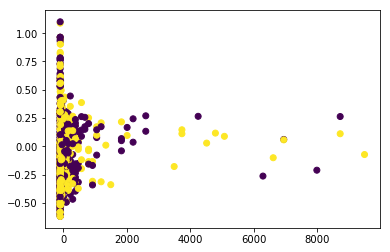

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df_transformed[:,0], df_transformed[:,1], c = df["class"])

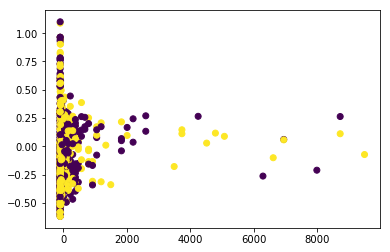

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df_transformed[:,0], df_transformed[:,1], c = df["class"])

In [45]:
my_minmax_scaler = preprocessing.MinMaxScaler(feature_range=(-0, 1))
my_minmax_scaler.fit(df[['article_counts','avg_sentiments']])
df_transformed=my_minmax_scaler.transform(df[['article_counts','avg_sentiments']])

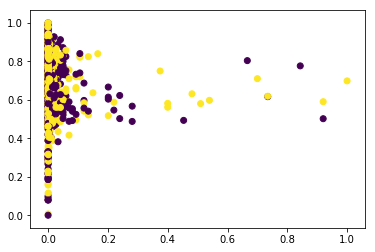

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df_transformed[:,0], df_transformed[:,1], c = df["class"])

In [47]:
from sklearn import preprocessing
my_scaler = preprocessing.StandardScaler()
my_scaler.fit(df[['article_counts','avg_sentiments']])
df_transformed=my_scaler.transform(df[['article_counts','avg_sentiments']])
df_transformed

array([[-0.15897346, -0.14705024],
       [-0.12404703, -1.03264184],
       [-0.15897346,  0.44255629],
       ...,
       [-0.07515003,  0.39593376],
       [ 0.26014367,  0.21112775],
       [ 3.83660986, -0.83852905]])

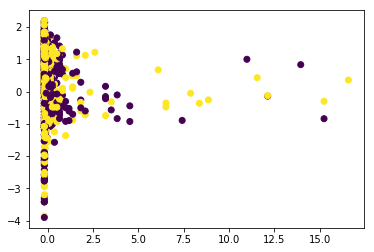

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df_transformed[:,0], df_transformed[:,1], c = df["class"])

In [11]:
df['class'].value_counts()

 0    1308
 1     465
-1     387
Name: class, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
            train_test_split(df[['article_counts','avg_sentiments']], df['class'], 
                             test_size=0.2,
                             random_state=1,
                             stratify=df['class']
                            )

X_train = X_train.values.reshape(-1,2)
X_test = X_test.values.reshape(-1,2)

## Choosing and fitting models

In [13]:
# Compare the five models and choose the best one
# Logistic regression
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=1)

# Support vector machine
from sklearn.svm import SVC
algorithm2 = SVC(kernel='rbf', random_state=1)

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
algorithm3 = DecisionTreeClassifier(random_state=1)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
algorithm4 = RandomForestClassifier(random_state=1)

# XGBoost
from xgboost import XGBClassifier
algorithm5 = XGBClassifier(random_state=1)

# Create a list of the five model instances
algorithms = [algorithm1, algorithm2, algorithm3, algorithm4, algorithm5]

In [14]:
# Compare the performance of the five models
for algorithm in algorithms:
    algorithm.fit(X_train, y_train)
    score = algorithm.score(X_test, y_test)
    name = algorithm.__class__.__name__
    
    print(f'{name} score: {score:.4f}')

LogisticRegression score: 0.6042
SVC score: 0.6019
DecisionTreeClassifier score: 0.4977
RandomForestClassifier score: 0.4977


C:\Users\kn_na\anaconda3\envs\x\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:37:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier score: 0.5648


## Cross Validation

In [15]:
# Create a list of the five model instances
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=1)

from sklearn.svm import SVC
algorithm2 = SVC(kernel='rbf', gamma="scale", C=1, random_state=1)

from sklearn.tree import DecisionTreeClassifier
algorithm3 = DecisionTreeClassifier(random_state=1)

from sklearn.ensemble import RandomForestClassifier
algorithm4 = RandomForestClassifier(random_state=1)

from xgboost import XGBClassifier
algorithm5 = XGBClassifier(random_state=1)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4, algorithm5]

In [16]:
# Compare the performance of the five models

# Create a balanced set of samples, create a StratifiedKFold instance
from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import cross_val_score

for algorithm in algorithms:
    # Conduct cross validation for each one of the five models
    scores = cross_val_score(algorithm, X_train, y_train, cv=stratifiedkfold)
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'{name} average score: {score:.4f} / each score: {scores}')

LogisticRegression average score: 0.6053 / each score: [0.60763889 0.60590278 0.60243056]
SVC average score: 0.6053 / each score: [0.60763889 0.60416667 0.60416667]
DecisionTreeClassifier average score: 0.4971 / each score: [0.5        0.46180556 0.52951389]
RandomForestClassifier average score: 0.5017 / each score: [0.51388889 0.46527778 0.52604167]
[11:37:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kn_na\anaconda3\envs\x\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:37:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier average score: 0.5312 / each score: [0.55034722 0.50868056 0.53472222]


## Grid Search

In [17]:
# Optimize the parameters
params = {'C':[1, 10, 100, 1000, 10000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
algorithm = SVC(random_state=1)

from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(algorithm, params, cv=stratifiedkfold)
gs.fit(X_train, y_train)

# Based on the best parameters, predict y values from test data
best = gs.best_estimator_
best_pred = best.predict(X_test)
print(best)

SVC(C=1, gamma=1e-05, random_state=1)


In [18]:
# Accuracy
score = best.score(X_test, y_test)
print(f'score: {score:.4f}')

# Confusion matrix
from sklearn.metrics import confusion_matrix
print('confusion matrix')
print(confusion_matrix(y_test, best_pred))

score: 0.6019
confusion matrix
[[  0  77   0]
 [  0 260   2]
 [  0  93   0]]
